In [1]:
# %%capture
# !pip install box2d-py

In [1]:
# T.cuda.get_device_name()

In [2]:
import os
import cv2
import gym
import time
import warnings

import numpy as np
import torch as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

## **Memory**

In [3]:
class Memory:
    def __init__(self):
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.states = []
        self.actions = []
        self.logprobs = []
        self.entropies = []
        self.rewards = []

    def store_step(self, state, action, logprob, entropy, reward):
        self.states.append(T.tensor(state, dtype=T.float32).to(self.device))
        self.actions.append(T.tensor(action, dtype=T.float32).to(self.device))
        self.logprobs.append(logprob) # HAS GRAD
        self.entropies.append(T.tensor(entropy, dtype=T.float32).to(self.device))
        self.rewards.append(T.tensor(reward, dtype=T.float32).to(self.device))
    
    def clear(self):
        del self.states[:]
        del self.actions[:]
        del self.logprobs[:]
        del self.entropies[:]
        del self.rewards[:]

    def __getitem__(self,i):
        state = self.states[i]
        action = self.actions[i]
        logprob = self.logprobs[i]
        entropy = self.entropies[i]
        reward = self.rewards[i]
        return(state, action, logprob, entropy, reward)

    def __len__(self):
        return len(self.states)

## **Network**

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, lr, observation_shape, n_actions, fc1_size, fc2_size, model_name, model_dir):
        super().__init__()
        self.model_dir = model_dir
        self.model_file = os.path.join(self.model_dir, model_name)
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size

        # ACTOR
        self.actor = nn.Sequential(
            nn.Linear(observation_shape[0], fc1_size),
            nn.ReLU(),
            nn.Linear(fc1_size, fc2_size),
            nn.ReLU(),
            nn.Linear(fc2_size, n_actions),
            nn.Softmax(dim=1)
        )

        # UTILS
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.RMSprop(self.parameters(), lr=lr, alpha=0.99)
        self.to(self.device)

    def forward(self, state):
        return self.actor(state)

    def save_model(self):
        print("[INFO] - Saving model")
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict()
        }
        T.save(checkpoint, self.model_file)
    
    def load_model(self, cpu=False):
        print("[INFO] - Loading model")
        
        map_location = T.device('cpu') if (cpu) else None
        
        checkpoint = T.load(self.model_file, map_location=map_location)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [5]:
class CriticNetwork(nn.Module):
    def __init__(self, lr, observation_shape, n_actions, fc1_size, fc2_size, model_name, model_dir):
        super().__init__()
        self.model_dir = model_dir
        self.model_file = os.path.join(self.model_dir, model_name)
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size

        # CRITIC
        self.critic = nn.Sequential(
            nn.Linear(observation_shape[0], fc1_size),
            nn.ReLU(),
            nn.Linear(fc1_size, fc2_size),
            nn.ReLU(),
            nn.Linear(fc2_size, 1),
        )

        # UTILS
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.loss = nn.SmoothL1Loss()
        self.optimizer = optim.RMSprop(self.parameters(), lr=lr, alpha=0.99)
        self.to(self.device)

    def forward(self, state):
        return self.critic(state)

    def save_model(self):
        print("[INFO] - Saving model")
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict()
        }
        T.save(checkpoint, self.model_file)
    
    def load_model(self, cpu=False):
        print("[INFO] - Loading model")
        
        map_location = T.device('cpu') if (cpu) else None
        
        checkpoint = T.load(self.model_file, map_location=map_location)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## **Agent**

In [6]:
class A2CAgent:
    def __init__(self, observation_shape, n_actions, actor_lr, critic_lr, fc1_size, fc2_size, gamma, 
                 learn_interval, algo_name, env_name, model_dir):
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.A_LR = actor_lr
        self.C_LR = critic_lr
        self.GAMMA = gamma
        self.memory = Memory()
        # MODEL PARAMS
        self.move_counter = 0
        self.learn_interval = learn_interval
        self.algo_name = algo_name
        self.env_name = env_name
        self.model_dir = model_dir
        # A1
        self.actor = ActorNetwork(actor_lr, observation_shape, n_actions, fc1_size, fc2_size,
                              model_name = env_name+'_'+algo_name+'actor',
                              model_dir = model_dir)
        # C1
        self.critic = CriticNetwork(actor_lr, observation_shape, n_actions, fc1_size, fc2_size,
                              model_name = env_name+'_'+algo_name+'critic',
                              model_dir = model_dir)

    def get_action(self, observation):
        observation = T.tensor([observation], dtype=T.float32).to(self.actor.device)
        action_probs = self.actor(observation)
        action_dist = T.distributions.Categorical(action_probs)
        action = action_dist.sample()
        logprob = action_dist.log_prob(action)
        entropy = action_dist.entropy()
        return action.item(), logprob, entropy.item()

    def learn(self, state_, terminal):

        # ADVANTAGE
        state_ = T.tensor([state_], dtype=T.float32).to(self.critic.device)
        Q = 0 if (terminal) else self.critic(state_)
        Q_values = []
        for *_, reward in zip(*(self.memory[::-1])):
            Q = reward + (self.GAMMA * Q)
            Q_values.insert(0, Q)
        
        Q_values = T.tensor(Q_values).to(self.critic.device)
        V_values = self.critic(T.stack(self.memory.states[:]))
        advantages = Q_values - V_values

        # CRITIC LOSS
        critic_loss = advantages.pow(2).mean()

        # ACTOR LOSS
        logprobs = T.stack(self.memory.logprobs[:])
        actor_loss = (-(logprobs * advantages.detach())).mean()

        # ENTROPY
        dist_entropy = T.stack(self.memory.entropies[:]).mean()

        loss = actor_loss + (critic_loss * 0.25) - (dist_entropy * 0.01)
        self.critic.optimizer.zero_grad()
        self.actor.optimizer.zero_grad()
        loss.backward()
        self.critic.optimizer.step()
        self.actor.optimizer.step()

  
    def save_models(self):
        self.actor.save_model()
        self.critic.save_model()

    def load_models(self, cpu=False):
        self.actor.load_model(cpu)
        self.critic.load_model(cpu)

## **Training**

In [7]:
env_name = "LunarLander-v2"
env = gym.make(env_name)

In [8]:
agent = A2CAgent(observation_shape=env.observation_space.shape,
                 n_actions=env.action_space.n,
                 actor_lr=7e-4,
                 critic_lr=7e-4,
                 fc1_size=400,
                 fc2_size=300,
                 gamma=0.99,
                 learn_interval=5,
                 algo_name='A2C',
                 env_name=env_name,
                 model_dir='./')

In [9]:
N_EPISODES = 3000

episode_rewards, episode_lengths, mean_rewards = [],[],[]
best_reward = -np.inf

In [ ]:
for episode_n in tqdm(range(N_EPISODES)):
    total_reward, total_moves = 0,0

    done = False
    observation = env.reset()

    while not done:
        agent.move_counter += 1

        action, logprob, entropy = agent.get_action(observation)
        observation_, reward, done, _ = env.step(action)

        agent.memory.store_step(observation, action, logprob, entropy, reward)
        total_reward += reward
        total_moves += 1

        if ((agent.move_counter % agent.learn_interval) == 0):
            agent.learn(observation_, done)
            agent.memory.clear()
        
        observation = observation_

    # IF DONE BUT MEM HAS ELEMENTS
    if (len(agent.memory) >= 2):
        agent.learn(observation_, done)
    agent.memory.clear()
        
    episode_rewards.append(total_reward)
    episode_lengths.append(total_moves)

    mean_reward = np.mean(episode_rewards[-100:])
    mean_rewards.append(mean_reward)
    if(mean_reward > best_reward):
        best_reward = mean_reward
        agent.save_models()
        
    print("ITER: ",episode_n,"\tRWD: ",round(total_reward,2),"\tM_RWD: ",round(mean_reward,2),"\tLEN: ",total_moves)

### **Results**

186.15663016244588

708625

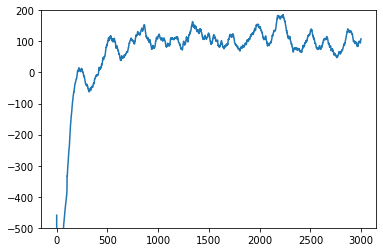

In [17]:
plt.ylim(-500,200)
plt.plot(mean_rewards)
display(best_reward)
display(np.sum(episode_lengths))

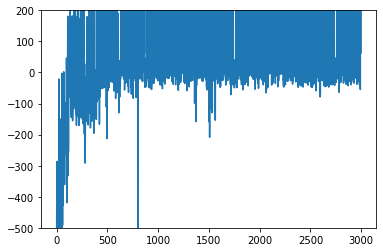

In [25]:
plt.ylim(-500,200)
plt.plot(episode_rewards)